In [6]:
%matplotlib inline

import numpy
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import descartes
import shapely.geometry, shapely.ops

import pymaxion
pymaxion.__version__

'0.0.1.dev19'

In [30]:
proj = pymaxion.DymaxionProjection()
bbox = (0, -90, 360, 90)
land = get_land()
area_idx = numpy.argsort([l.area for l in land])
shapes = shapely.geometry.MultiPolygon([land[int(i)] for i in area_idx[-1:-7:-1]])
shape = shapes[0]

proj = pymaxion.DymaxionProjection()
face_idxs = (0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18)

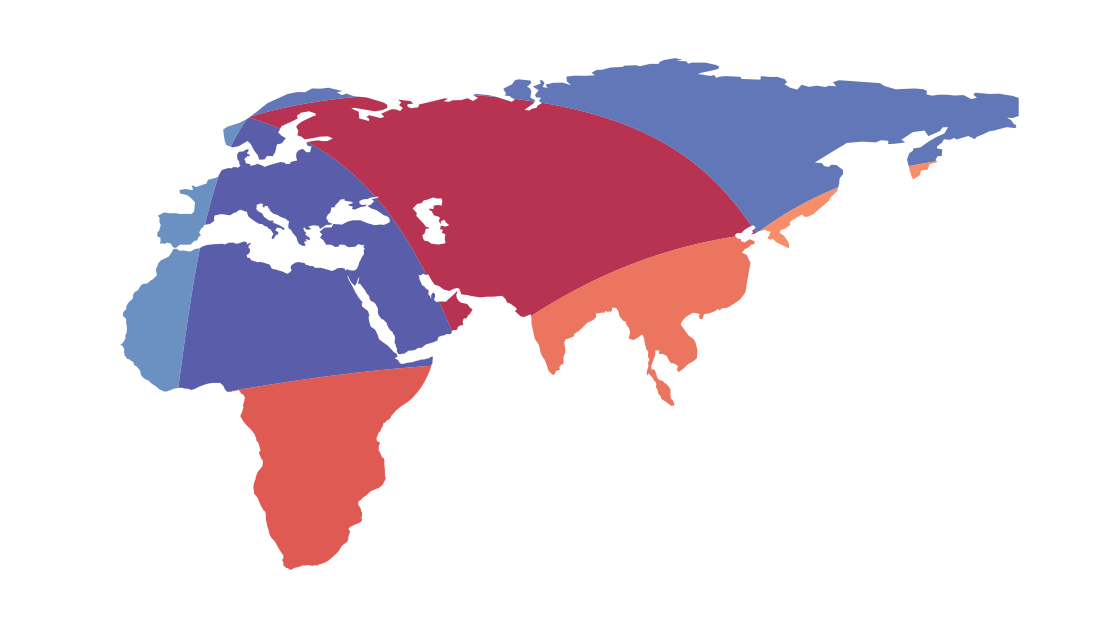

In [39]:
fig = plt.figure(figsize=(21, 11))
axes = plt.gca()
face_idxs = (0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17, 18)
problems = (8, 13)
colorlist = alternate_colors('RdYlBu_r', 19)

for face_idx in face_idxs:
    # Define transform functions
    centre = numpy.degrees(cartesian_to_spherical(*proj.face_centres[face_idx]))
    transform = lambda s: shapely.ops.transform(
        sterographic_projection(centre[0], centre[1], longlat=True), s)
    itransform = lambda s: shapely.ops.transform(
        inverse_sterographic_projection(centre[0], centre[1], longlat=True), s)

    # Get intersection of poly with face
    intersect = proj.get_poly_intersection(shape, face_idx)
    if intersect.is_empty:
        continue
    else:
        intersect = pymaxion.operations.fix_longitude(intersect)

    # Plot part of poly
    color = colorlist[face_idx]
    if intersect.type.startswith('Multi'):
        for poly in intersect:
            axes.add_patch(descartes.PolygonPatch(
                poly, facecolor=color, edgecolor='none', alpha=0.8))
    else:
        axes.add_patch(descartes.PolygonPatch(
                intersect, facecolor=color, edgecolor='none', alpha=0.8))

set_bounds(shape.bounds)
axes.set_axis_off()
fig.savefig('subpoly.png')

In [ ]:
proj = pymaxion.DymaxionProjection()
hemisphere = (0.5, -1, 2.5, 1)
graticules = make_grid(bbox=bbox, npoints=200, graticule_spacing=20)
gnomonic = gnomonic_projection(90, 0)

# formats
gfmt = dict(color='gray', dashes=(4, 2), alpha=0.5)
lfmt = dict(color='gray', linewidth=2)
ffmt = dict(color='red', linewidth=2)
cfmt = dict(color='red', marker='o', markeredgecolor='none', linewidth=0)
face_fmt = dict(facecolor='none', edgecolor='gray', alpha=0.8, linewidth=2, zorder=4)

def plot_face(face_idx):
    transform = lambda pts: \
        cartesian_to_spherical(*numpy.dot(proj.face_rotation_matrices[face_idx], pts))

    fig1 = plt.figure(figsize=(11,21))
    ax2 = fig1.gca()
    ax2.set_aspect('equal')

    # Plot face location
    face_points = proj.vertices[proj.faces[face_idx]]
    face_points = numpy.vstack([face_points, face_points[0]]).transpose()
    face_points = transform(face_points)
    face_centre = proj.face_centres[face_idx]
    face_centre = transform(face_centre)
    face_poly = shapely.geometry.Polygon(numpy.asarray(gnomonic(*face_points)).transpose())
    ax2.add_patch(descartes.PolygonPatch(face_poly, **face_fmt))

    # Make plots
    for geom in graticules:
        # Transform and cut out points that are not neccesary
        points = numpy.radians(geom.coords).transpose()
        points = spherical_to_cartesian(*points)
        points = transform(points)

        # Generate gnomonic projection of points
        mask = is_inside_bbox(hemisphere, points)
        if any(mask):
            try:
                line = shapely.geometry.LineString(
                    numpy.asarray(gnomonic(*points[:, mask])).transpose()
                ).intersection(face_poly)
                if line.type.startswith('Multi'):
                    for l in line:
                        ax2.plot(*l.xy, **gfmt)
                else:
                    ax2.plot(*line.xy, **gfmt)
            except:
                pass

    for geom in shapes.boundary:
        # Transform and cut out points that are not neccesary
        points = numpy.radians(geom.coords).transpose()
        points = spherical_to_cartesian(*points)
        points = transform(points)

        # Generate gnomonic projection of points
        mask = is_inside_bbox(hemisphere, points)
        if any(mask):
            try:
                boundary = shapely.geometry.LineString(
                    numpy.asarray(gnomonic(*points[:, mask])).transpose())
                if len(boundary) < 4:
                    continue
                poly = shapely.geometry.Polygon(boundary)
                ax2.add_patch(descartes.PolygonPatch(
                    poly, facecolor='white', edgecolor='none', zorder=3))
                boundary = boundary.intersection(face_poly)
                if boundary.type.startswith('Multi'):
                    for b in boundary:
                        ax2.plot(*b.xy, color='black', linewidth=2, zorder=10)
                else:
                    ax2.plot(*boundary.xy, color='black', linewidth=2, zorder=10)
            except:
                pass

    # Mask out everything outside the triangle
    xbounds, ybounds = ax2.get_xlim(), ax2.get_ylim()
    mask = shapely.geometry.box(xbounds[0], ybounds[0], xbounds[1], ybounds[1]).difference(face_poly)
#     ax2.add_patch(descartes.PolygonPatch(
#             mask, facecolor='white', edgecolor='none',
#             linewidth=0, zorder=10))
    ax2.set_axis_off()

In [ ]:
boundary = shapely.geometry.MultiLineString([numpy.radians(c.coords) for c in land[101].boundary])
print([b.is_valid for b in boundary])
boundary

In [ ]:
for face_idx in range(20):
    transform = lambda pts: \
        cartesian_to_spherical(*numpy.dot(
                proj.face_rotation_matrices[face_idx], pts))        

    face_points = proj.vertices[proj.faces[face_idx]]
    face_points = numpy.vstack([face_points, face_points[0]]).transpose()
    face_points = transform(face_points)
    face_centre = proj.face_centres[face_idx]
    face_centre = transform(face_centre)
    face_poly = shapely.geometry.Polygon(numpy.asarray(gnomonic(*face_points)).transpose())

    for geom in shapes.boundary:
        # Transform and cut out points that are not neccesary
        points = numpy.radians(geom.coords).transpose()
        points = spherical_to_cartesian(*points)
        points = transform(points)        
        intsec = boundary.intersection(face_poly)
        if not intsec.is_empty:
            plt.figure()
            plt.plot(*face_poly.boundary.xy)
            plt.plot(*intsec.boundary.xy)
    

In [ ]:
for idx in range(len(proj.faces)):
    plot_face(idx)